<a href="https://colab.research.google.com/github/HamsiniDurga/bda-tsa/blob/main/BDA_TSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing required Libraries

In [2]:
import pandas as pd
import numpy as np
 
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from textblob import TextBlob

import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf

In [3]:
%pip install https://github.com/Xtra-Computing/thundersvm/releases/download/v0.3.4/thundersvm_cuda10.1-0.3.4-cp36-cp36m-linux_x86_64.whl

     |████████████████████████████████| 522kB 183kB/s 


In [4]:
from thundersvm import SVC

# GPU libraries

In [ ]:
pip install numba


In [ ]:
#pip install cudatoolkit
from numba import jit, cuda 

# Reading Dataset

In [5]:
path = '/content/drive/My Drive/training.1600000.processed.noemoticon.csv'

In [9]:
import chardet
with open(path, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'confidence': 0.99, 'encoding': 'utf-8', 'language': ''}

In [6]:
columns = ["target", "ids", "date", "flag", "user", "text"]
df = pd.read_csv(path,encoding='ISO-8859-1',names = columns)
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


# EDA

In [9]:
df.shape

(1600000, 6)

 Positive negative tweets distribution

In [10]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [11]:
target = df.target.apply(lambda x: decode_sentiment(x))

Text(0.5, 1.0, 'Dataset labels distribuition')

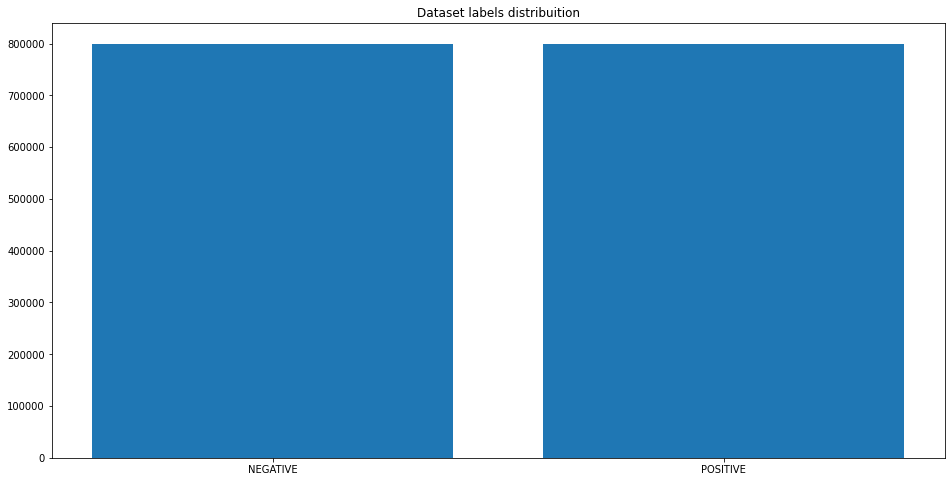

In [12]:
target_cnt = Counter(target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [13]:
tf.test.gpu_device_name()


'/device:GPU:0'

In [14]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-2b30eda4-5bd5-95c2-af9e-ee5516d7dbfb)


word cloud

Positive word cloud

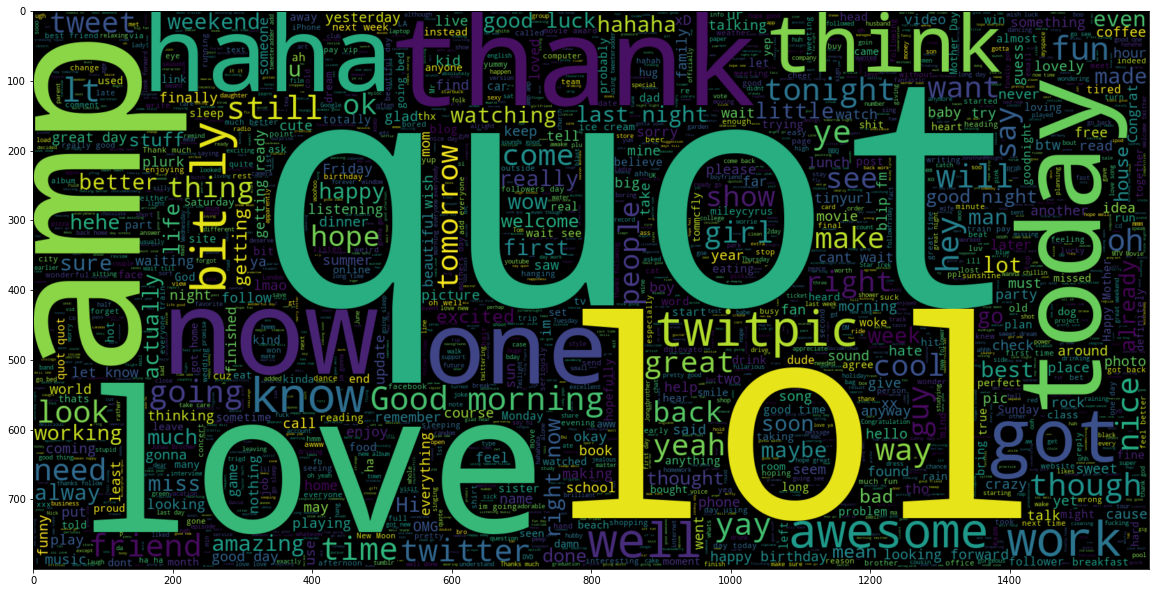

In [15]:
from wordcloud import WordCloud

with tf.device('/gpu:0'):
  plt.figure(figsize = (20,20)) 
  wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[target == 'POSITIVE'].text))
  plt.imshow(wc , interpolation = 'bilinear')

Negative word cloud

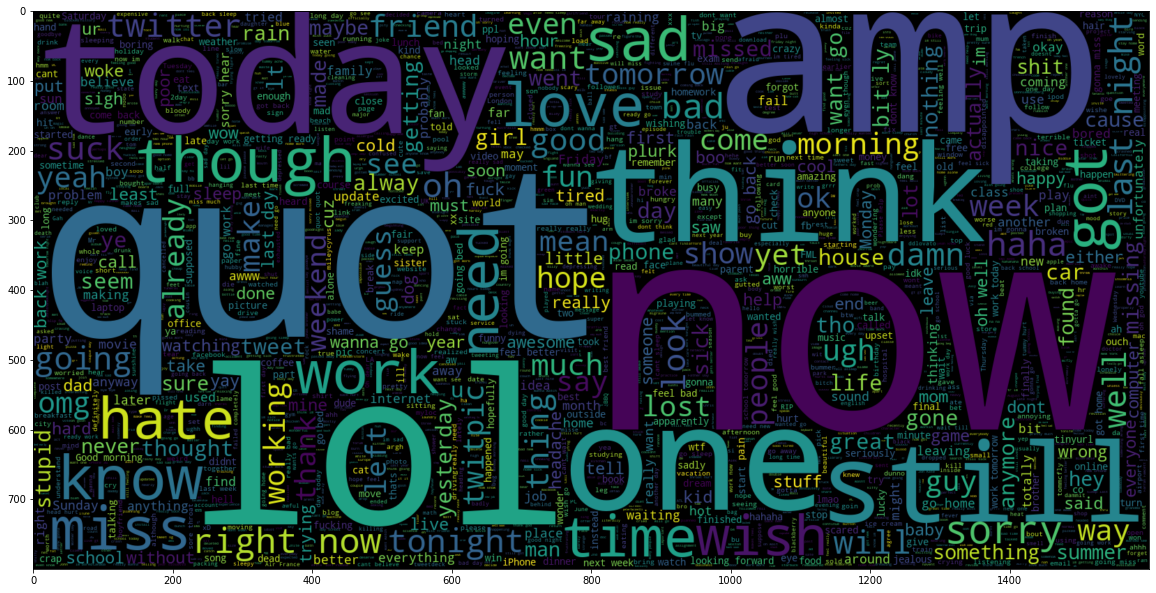

In [16]:
from wordcloud import WordCloud

with tf.device('/gpu:0'):
  plt.figure(figsize = (20,20)) 
  wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[target == 'NEGATIVE'].text))
  plt.imshow(wc , interpolation = 'bilinear')

# Data Preprocessing

Function for removing twitter handles

In [7]:
#@jit(nopython=True, boundscheck=True)                        
def remove_pattern(input_txt, pattern):  
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

Remove punctuations and special characters and twitter handles



In [ ]:
#%%time

df['clean_tweet'] = np.vectorize(remove_pattern)(df['text'], "@[\w]*")  #remove twitter handle
df['clean_tweet'] = df['clean_tweet'].str.replace("[^a-zA-Z#]", " ")  #remove punctuations, numbers and special characters
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3])) #remove short words


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

 Text Normalisation

In [ ]:
%%time
with tf.device('gpu:0'):
  tokenized_tweet = df['clean_tweet'].apply(lambda x: x.split()) # tokenizing
  stemmer = PorterStemmer()
  tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming

  for i in range(len(tokenized_tweet)):
      tokenized_tweet[i] = " ".join(str(x) for x in tokenized_tweet[i])
      
  df['clean_tweet'] = tokenized_tweet

CPU times: user 3min 31s, sys: 1.05 s, total: 3min 32s
Wall time: 3min 37s


In [ ]:
df.head()

,target,ids,date,flag,user,text,clean_tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",http twitpic awww that bummer shoulda david ca...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset that updat facebook text might result sc...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,dive mani time ball manag save rest bound
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",behav here becaus over there


# Train Test split

In [ ]:
%%time
TRAIN_SIZE = 0.8
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)

CPU times: user 1.61 s, sys: 14 ms, total: 1.62 s
Wall time: 1.63 s


# TF-IDF Vectoriser

In [ ]:
%%time
vectorizer = TfidfVectorizer(min_df = 5,max_df = 0.8,sublinear_tf = True,use_idf = True)
train_vectors = vectorizer.fit_transform(df_train['clean_tweet'])
test_vectors = vectorizer.transform(df_test['clean_tweet'])

CPU times: user 12.3 s, sys: 42.9 ms, total: 12.3 s
Wall time: 12.3 s


# SVM Model Full Dataset

create classifier

In [ ]:
%%time
classifier_linear = SVC(C=100, kernel='rbf')

CPU times: user 79 µs, sys: 2 µs, total: 81 µs
Wall time: 83.9 µs


fit the model

In [ ]:
%%time
classifier_linear.fit(train_vectors, df_train['target'])

In [ ]:
prediction_linear = classifier_linear.predict(test_vectors)

In [ ]:
report_svm = classification_report(df_test['target'], prediction_linear, output_dict=True)
df_test["predicted_svm"]=prediction_linear
cm_svm=confusion_matrix(df_test["label"],df_test["predicted_svm"])

# Random Forest Full dataset

In [ ]:
%%time
rf = RandomForestClassifier(n_estimators=150, random_state=11).fit(train_vectors, df_train["target"])
prediction_rf = rf.predict(test_vectors)
report_rf = classification_report(df_test["target"], prediction_rf, output_dict=True)
df_test["predicted_rf"]=prediction_rf

cm_rf=confusion_matrix(df_test["target"],df_test["predicted_rf"])
print(classification_report(df_test["target"],df_test["predicted_rf"])) 
print(accuracy_score(df_test["target"],df_test["predicted_rf"]))

accuracy score

In [ ]:
print(classification_report(df_test["label"],dftest["predicted_svm"])) 
print(accuracy_score(df_test["label"],df_test["predicted_svm"]))

# Sampling


In [8]:
import random
 
'''with open(path, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result'''

n = sum(1 for line in open(path,encoding='ISO-8859-1'))-1  # Calculate number of rows in file
s = n//10  # sample size of 10%
skip = sorted(random.sample(range(1, n+1), n-s))  # n+1 to compensate for header 

df_sample = pd.read_csv(path,encoding='ISO-8859-1',names = columns,skiprows=skip)

df_sample.shape

(160000, 6)

# EDA Sampled Dataset

Text(0.5, 1.0, 'Sampled Dataset labels distribuition')

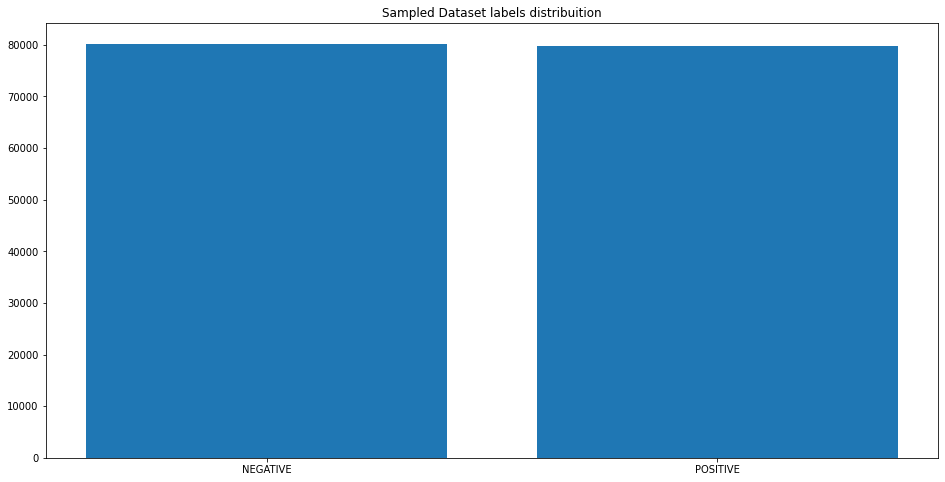

In [ ]:
target_sample = df_sample.target.apply(lambda x: decode_sentiment(x))

target_cnt_sample = Counter(target_sample)

plt.figure(figsize=(16,8))
plt.bar(target_cnt_sample.keys(), target_cnt_sample.values())
plt.title("Sampled Dataset labels distribuition")

# ML Model - Sampled Dataset



In [9]:
%%time
df_sample['clean_tweet'] = np.vectorize(remove_pattern)(df_sample['text'], "@[\w]*")  #remove twitter handle
df_sample['clean_tweet'] = df_sample['clean_tweet'].str.replace("[^a-zA-Z#]", " ")  #remove punctuations, numbers and special characters
df_sample['clean_tweet'] = df_sample['clean_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3])) #remove short words


CPU times: user 5.25 s, sys: 243 ms, total: 5.49 s
Wall time: 5.5 s


In [15]:
%%time
tokenized_tweet = df_sample['clean_tweet'].apply(lambda x: x.split()) # tokenizing
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming

for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = " ".join(str(x) for x in tokenized_tweet[i])
    
df_sample['clean_tweet'] = tokenized_tweet

CPU times: user 19.1 s, sys: 76.3 ms, total: 19.2 s
Wall time: 19.2 s


In [10]:
df_sample.head()

,target,ids,date,flag,user,text,clean_tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",http twitpic Awww that bummer shoulda David Ca...
1,0,1467813579,Mon Apr 06 22:20:31 PDT 2009,NO_QUERY,starkissed,@LettyA ahh ive always wanted to see rent lov...,always wanted rent love soundtrack
2,0,1467813782,Mon Apr 06 22:20:34 PDT 2009,NO_QUERY,gi_gi_bee,@FakerPattyPattz Oh dear. Were you drinking ou...,dear Were drinking forgotten table drinks
3,0,1467814180,Mon Apr 06 22:20:40 PDT 2009,NO_QUERY,viJILLante,this week is not going as i had hoped,this week going hoped
4,0,1467814192,Mon Apr 06 22:20:41 PDT 2009,NO_QUERY,Ljelli3166,blagh class at 8 tomorrow,blagh class tomorrow


train test split

In [18]:
%%time
TRAIN_SIZE = 0.8
df_train_sample, df_test_sample = train_test_split(df_sample, test_size=1-TRAIN_SIZE, random_state=42)

CPU times: user 69.2 ms, sys: 0 ns, total: 69.2 ms
Wall time: 69.5 ms


tf-idf vectoriser

In [19]:
%%time
vectorizer = TfidfVectorizer(min_df = 5,max_df = 0.8,sublinear_tf = True,use_idf = True,stop_words='english')
train_vectors_sample = vectorizer.fit_transform(df_train_sample['clean_tweet'])
test_vectors_sample = vectorizer.transform(df_test_sample['clean_tweet'])

CPU times: user 1.73 s, sys: 16 ms, total: 1.75 s
Wall time: 1.75 s


random forest

In [28]:
%%time
rf_s = RandomForestClassifier(n_estimators=150, random_state=11).fit(train_vectors_sample, df_train_sample["target"])
prediction_rf_s = rf_s.predict(test_vectors_sample)
report_rf_s = classification_report(df_test_sample["target"], prediction_rf_s, output_dict=True)
df_test_sample["predicted_rf"]=prediction_rf_s

cm_rf_s=confusion_matrix(df_test_sample["target"],df_test_sample["predicted_rf"])
print(classification_report(df_test_sample["target"],df_test_sample["predicted_rf"])) 
print(accuracy_score(df_test_sample["target"],df_test_sample["predicted_rf"]))


              precision    recall  f1-score   support

           0       0.74      0.71      0.72     15904
           4       0.72      0.75      0.74     16096

    accuracy                           0.73     32000
   macro avg       0.73      0.73      0.73     32000
weighted avg       0.73      0.73      0.73     32000

0.7288125
CPU times: user 12min 49s, sys: 1.37 s, total: 12min 51s
Wall time: 12min 51s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


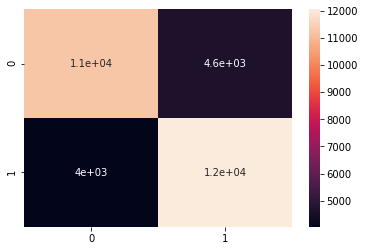

In [31]:
cf_matrix = confusion_matrix(df_test_sample["target"],df_test_sample["predicted_rf"])
sns.heatmap(cf_matrix, annot=True)
#sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%')
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
#sns.heatmap(cf_matrix, annot=labels, fmt='')

support vector machine

In [20]:
%%time
#thunder svm, utilises GPU, unlike sklearn
clf = SVC(C=100, kernel='rbf')
clf.fit(train_vectors_sample, df_train_sample['target'])

CPU times: user 5.16 s, sys: 6.93 s, total: 12.1 s
Wall time: 13 s


In [21]:
prediction_linear = clf.predict(test_vectors_sample)

report_svm = classification_report(df_test_sample['target'], prediction_linear, output_dict=True)
df_test_sample["predicted_svm"]=prediction_linear
cm_svm_s=confusion_matrix(df_test_sample["target"],df_test_sample["predicted_svm"])

print(classification_report(df_test_sample["target"],df_test_sample["predicted_svm"])) 
print(accuracy_score(df_test_sample["target"],df_test_sample["predicted_svm"]))

              precision    recall  f1-score   support

           0       0.74      0.70      0.72     15904
           4       0.72      0.76      0.74     16096

    accuracy                           0.73     32000
   macro avg       0.73      0.73      0.73     32000
weighted avg       0.73      0.73      0.73     32000

0.732625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


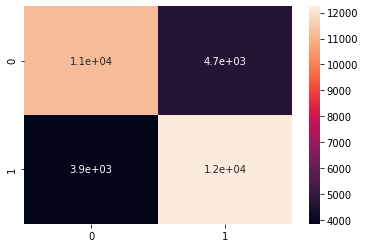

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(df_test_sample["target"],df_test_sample["predicted_svm"])
sns.heatmap(cf_matrix, annot=True)
#sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%')
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
#sns.heatmap(cf_matrix, annot=labels, fmt='')

random forest optimise

In [ ]:
from sklearn.model_selection import RandomizedSearchCV


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 30, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 200, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_vectors_sample, df_train_sample["target"])

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 24.0min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 96.8min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = accuracy_score(test_labels,predictions)
    #accuracy=100-mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy

In [ ]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, test_vectors_sample, df_test_sample['target'])

Model Performance
Average Error: 1.0735 degrees.
Accuracy = 0.73%.


Text Blob

In [16]:
%%time
def analyze_sentiment_TextBlob(tweet):
    
    analysis=TextBlob(tweet)
        
    if analysis.sentiment.polarity >= 0:
        return 0
    else:
        return 1 
        
df_sample['predicted_textblob']=np.array([analyze_sentiment_TextBlob(tweet) for tweet in df_sample['clean_tweet']])
cm_TextBlob=confusion_matrix(df_sample["target"],df_sample["predicted_textblob"])

print(classification_report(df_sample["target"],df_sample["predicted_textblob"])) 
print(accuracy_score(df_sample["target"],df_sample["predicted_textblob"]))

              precision    recall  f1-score   support

           0       0.45      0.73      0.55     80176
           1       0.00      0.00      0.00         0
           4       0.00      0.00      0.00     79824

    accuracy                           0.36    160000
   macro avg       0.15      0.24      0.18    160000
weighted avg       0.22      0.36      0.28    160000

0.36443125
CPU times: user 1min 19s, sys: 82.2 ms, total: 1min 19s
Wall time: 1min 19s


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
from textblob import classifiers
classifier = classifiers.NaiveBayesClassifier(df_sample["text"])

NameError: ignored

# k fold sampling

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


              precision    recall  f1-score   support

           0       0.76      0.71      0.73     15840
           4       0.73      0.78      0.75     16160

    accuracy                           0.74     32000
   macro avg       0.74      0.74      0.74     32000
weighted avg       0.74      0.74      0.74     32000

0.742625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


              precision    recall  f1-score   support

           0       0.75      0.71      0.73     15844
           4       0.73      0.77      0.75     16156

    accuracy                           0.74     32000
   macro avg       0.74      0.74      0.74     32000
weighted avg       0.74      0.74      0.74     32000

0.7404375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


              precision    recall  f1-score   support

           0       0.76      0.71      0.73     15908
           4       0.73      0.77      0.75     16092

    accuracy                           0.74     32000
   macro avg       0.74      0.74      0.74     32000
weighted avg       0.74      0.74      0.74     32000

0.7441875
CPU times: user 1min 48s, sys: 15.4 s, total: 2min 3s
Wall time: 2min 5s


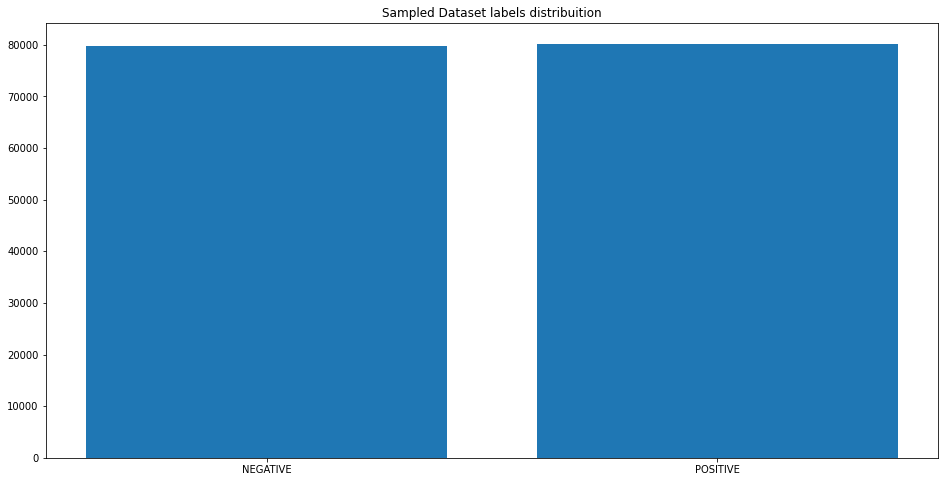

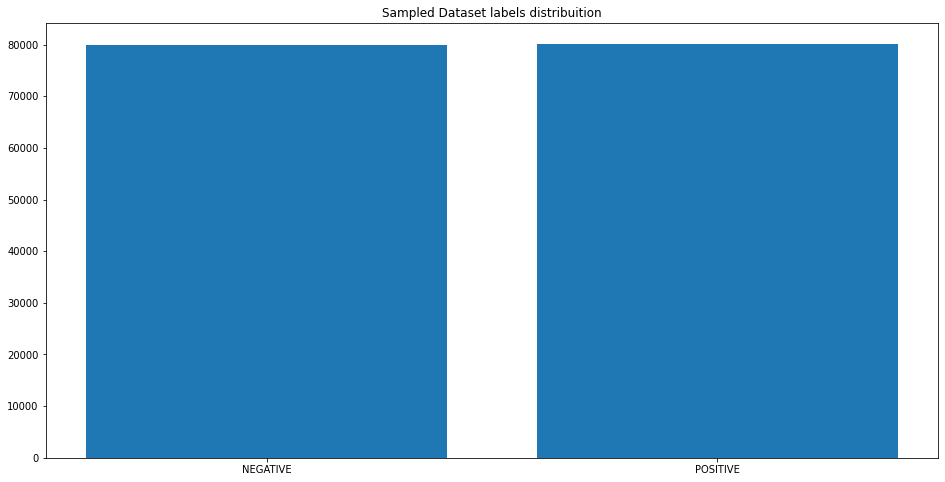

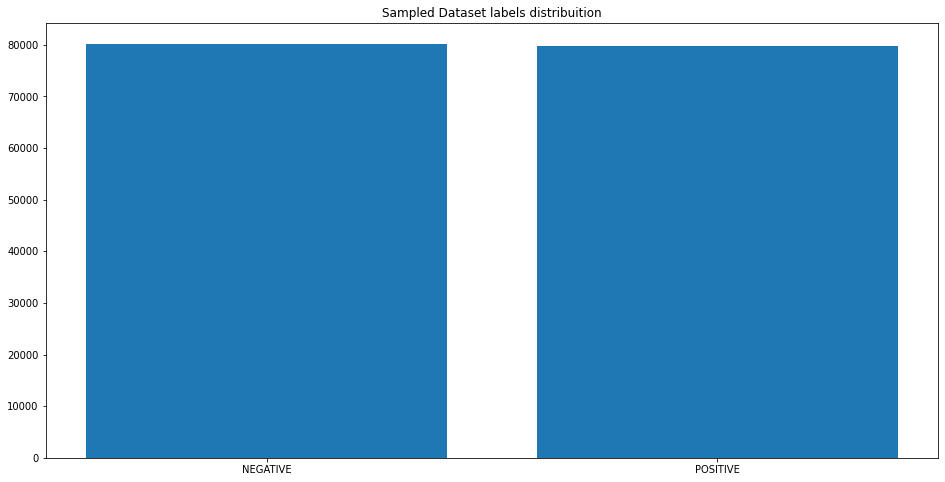

In [ ]:
%%time
import random

for i in range(3):
  n = sum(1 for line in open(path,encoding='ISO-8859-1'))-1  # Calculate number of rows in file
  s = n//10  # sample size of 10%
  skip = sorted(random.sample(range(1, n+1), n-s))  # n+1 to compensate for header 

  df_sample = pd.read_csv(path,encoding='ISO-8859-1',names = columns,skiprows=skip)

  df_sample.shape

  target_sample = df_sample.target.apply(lambda x: decode_sentiment(x))

  target_cnt_sample = Counter(target_sample)

  plt.figure(figsize=(16,8))
  plt.bar(target_cnt_sample.keys(), target_cnt_sample.values())
  plt.title("Sampled Dataset labels distribuition")

  df_sample['clean_tweet'] = np.vectorize(remove_pattern)(df_sample['text'], "@[\w]*")  #remove twitter handle
  df_sample['clean_tweet'] = df_sample['clean_tweet'].str.replace("[^a-zA-Z#]", " ")  #remove punctuations, numbers and special characters
  df_sample['clean_tweet'] = df_sample['clean_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3])) #remove short words

  tokenized_tweet = df_sample['clean_tweet'].apply(lambda x: x.split()) # tokenizing
  stemmer = PorterStemmer()
  tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming

  for i in range(len(tokenized_tweet)):
      tokenized_tweet[i] = " ".join(str(x) for x in tokenized_tweet[i])
      
  df_sample['clean_tweet'] = tokenized_tweet
  df_sample.head()

  TRAIN_SIZE = 0.8
  df_train_sample, df_test_sample = train_test_split(df_sample, test_size=1-TRAIN_SIZE, random_state=42)

  vectorizer = TfidfVectorizer(min_df = 5,max_df = 0.8,sublinear_tf = True,use_idf = True)
  train_vectors_sample = vectorizer.fit_transform(df_train_sample['clean_tweet'])
  test_vectors_sample = vectorizer.transform(df_test_sample['clean_tweet'])

  clf = SVC(C=200, kernel='sigmoid')
  clf.fit(train_vectors_sample, df_train_sample['target'])

  prediction_linear = clf.predict(test_vectors_sample)

  report_svm = classification_report(df_test_sample['target'], prediction_linear, output_dict=True)
  df_test_sample["predicted_svm"]=prediction_linear
  cm_svm_s=confusion_matrix(df_test_sample["target"],df_test_sample["predicted_svm"])

  print(classification_report(df_test_sample["target"],df_test_sample["predicted_svm"])) 
  print(accuracy_score(df_test_sample["target"],df_test_sample["predicted_svm"]))

# Coronavirus tweets


In [39]:
path2 = "/content/drive/MyDrive/16th april tweets.csv"

df_corona = pd.read_csv(path2)

In [40]:
df_corona.head()

,Unnamed: 0,status_id,user_id,created_at,screen_name,text,source,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,is_retweet,favourites_count,retweet_count,country_code,place_full_name,place_type,followers_count,friends_count,account_lang,account_created_at,verified,lang,dates
0,5,1250574629627760640,15872418,2020-04-16T00:00:00Z,ABSCBNNews,G20 agrees to debt relief for poorest countrie...,TweetDeck,NaN,NaN,NaN,False,False,1075,0,NaN,NaN,NaN,6850273,1072,NaN,2008-08-16T10:09:33Z,True,en,2020-04-16
1,7,1250574626880552960,171548670,2020-04-16T00:00:00Z,RadioNLNews,B.C. health officials are urging people to kin...,TweetDeck,NaN,NaN,NaN,False,False,501,0,NaN,NaN,NaN,6935,2137,NaN,2010-07-27T16:17:02Z,False,en,2020-04-16
2,9,1250574627061055490,23517017,2020-04-16T00:00:00Z,953WDAE,The Lovely Lisa Ann Joins The Show LIVE From N...,TweetDeck,NaN,NaN,NaN,False,False,13891,0,NaN,NaN,NaN,25074,8321,NaN,2009-03-09T22:45:09Z,False,en,2020-04-16
3,10,1250574627631292416,613510703,2020-04-16T00:00:00Z,matanock,@allisonnamias @ArriolaLR As @ethanbdm referen...,TweetDeck,1.248266e+18,613510703.0,matanock,False,False,327,0,NaN,NaN,NaN,1624,400,NaN,2012-06-20T15:11:57Z,False,en,2020-04-16
4,11,1250574629812473860,38489678,2020-04-16T00:00:00Z,JAMA_current,Study suggests higher rates of co-infection be...,Sprinklr,NaN,NaN,NaN,False,False,1357,130,NaN,NaN,NaN,354174,805,NaN,2009-05-07T18:45:39Z,True,en,2020-04-16


In [41]:
new = df_corona[['created_at','text']].copy()

In [42]:
new.head()

,created_at,text
0,2020-04-16T00:00:00Z,G20 agrees to debt relief for poorest countrie...
1,2020-04-16T00:00:00Z,B.C. health officials are urging people to kin...
2,2020-04-16T00:00:00Z,The Lovely Lisa Ann Joins The Show LIVE From N...
3,2020-04-16T00:00:00Z,@allisonnamias @ArriolaLR As @ethanbdm referen...
4,2020-04-16T00:00:00Z,Study suggests higher rates of co-infection be...


In [43]:
%%time
new['clean_tweet'] = np.vectorize(remove_pattern)(new['text'], "@[\w]*")  #remove twitter handle
new['clean_tweet'] = new['clean_tweet'].str.replace("[^a-zA-Z#]", " ")  #remove punctuations, numbers and special characters
new['clean_tweet'] = new['clean_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3])) #remove short words

CPU times: user 12.4 s, sys: 464 ms, total: 12.9 s
Wall time: 12.9 s


In [44]:
%%time
tokenized_tweet = new['clean_tweet'].apply(lambda x: x.split()) # tokenizing
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming

for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = " ".join(str(x) for x in tokenized_tweet[i])
    
new['clean_tweet'] = tokenized_tweet

CPU times: user 1min 29s, sys: 364 ms, total: 1min 30s
Wall time: 1min 30s


In [45]:
new.head()

,created_at,text,clean_tweet
0,2020-04-16T00:00:00Z,G20 agrees to debt relief for poorest countrie...,agre debt relief poorest countri amid pandem #...
1,2020-04-16T00:00:00Z,B.C. health officials are urging people to kin...,health offici urg peopl kind jump conclus abou...
2,2020-04-16T00:00:00Z,The Lovely Lisa Ann Joins The Show LIVE From N...,love lisa join show live from #nfl #mlb #covid...
3,2020-04-16T00:00:00Z,@allisonnamias @ArriolaLR As @ethanbdm referen...,referenc just thi version ebola lesson #covid ...
4,2020-04-16T00:00:00Z,Study suggests higher rates of co-infection be...,studi suggest higher rate infect between #sars...


In [46]:
%%time
vectorizer = TfidfVectorizer(min_df = 5,max_df = 0.8,sublinear_tf = True,use_idf = True,stop_words='english')
train_vectors_sample_new = vectorizer.fit_transform(new['clean_tweet'])

CPU times: user 5.68 s, sys: 48.3 ms, total: 5.73 s
Wall time: 5.73 s


In [48]:
%%time
prediction_linear_new = clf.predict(train_vectors_sample_new)

CPU times: user 6.75 s, sys: 9.34 s, total: 16.1 s
Wall time: 16.1 s


In [49]:
new["predicted_svm"]=prediction_linear_new

In [50]:
new.head()

,created_at,text,clean_tweet,predicted_svm
0,2020-04-16T00:00:00Z,G20 agrees to debt relief for poorest countrie...,agre debt relief poorest countri amid pandem #...,4.0
1,2020-04-16T00:00:00Z,B.C. health officials are urging people to kin...,health offici urg peopl kind jump conclus abou...,4.0
2,2020-04-16T00:00:00Z,The Lovely Lisa Ann Joins The Show LIVE From N...,love lisa join show live from #nfl #mlb #covid...,4.0
3,2020-04-16T00:00:00Z,@allisonnamias @ArriolaLR As @ethanbdm referen...,referenc just thi version ebola lesson #covid ...,4.0
4,2020-04-16T00:00:00Z,Study suggests higher rates of co-infection be...,studi suggest higher rate infect between #sars...,4.0


In [52]:
def analyze_sentiment_TextBlob(tweet):
    
    analysis=TextBlob(tweet)
        
    if analysis.sentiment.polarity >= 0:
        return 0
    else:
        return 1 
        
new['predicted_textblob']=np.array([analyze_sentiment_TextBlob(tweet) for tweet in new['clean_tweet']])

,created_at,text,clean_tweet,predicted_svm,predicted_textblob
0,2020-04-16T00:00:00Z,G20 agrees to debt relief for poorest countrie...,agre debt relief poorest countri amid pandem #...,4.0,0
1,2020-04-16T00:00:00Z,B.C. health officials are urging people to kin...,health offici urg peopl kind jump conclus abou...,4.0,0
2,2020-04-16T00:00:00Z,The Lovely Lisa Ann Joins The Show LIVE From N...,love lisa join show live from #nfl #mlb #covid...,4.0,0
3,2020-04-16T00:00:00Z,@allisonnamias @ArriolaLR As @ethanbdm referen...,referenc just thi version ebola lesson #covid ...,4.0,0
4,2020-04-16T00:00:00Z,Study suggests higher rates of co-infection be...,studi suggest higher rate infect between #sars...,4.0,1


In [55]:
new.to_csv('new.csv')
!cp new.csv "drive/My Drive/"

[Text(0, 0, 'Positive'), Text(0, 0, 'Negative')]

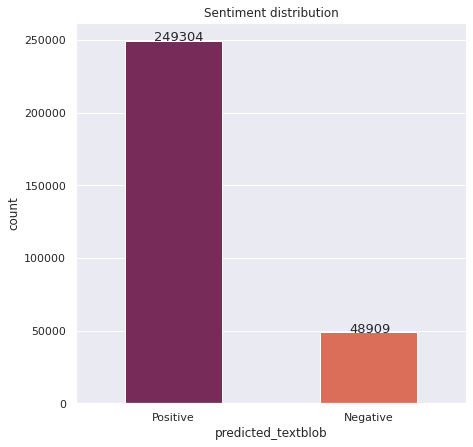

In [127]:
import seaborn as sns
#sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(7,7)})
labels = ['Positive', 'Negative']

ax = sns.countplot(x="predicted_textblob", data=new, palette="rocket")
for i in ax.patches:
  ax.text(x=i.get_x()+0.3,y=i.get_height(), s=str(i.get_height()),fontsize=13)
  i.set_width(0.5)
  i.set_x(i.get_x()+0.15)

ax.set_title('Sentiment distribution')

ax.set_xticklabels(labels)


In [128]:
new2 = pd.read_csv('/content/drive/MyDrive/23rd april tweets.csv')

In [129]:
new2 = new2[['created_at','text']].copy()

In [130]:
new2.head()

,created_at,text
0,2020-04-23T00:00:00Z,"Team sports may return to B.C. soon, but thing..."
1,2020-04-23T00:00:00Z,Duterte adviser proposes gradual reopening of ...
2,2020-04-23T00:00:00Z,#Coronavirus #COVID19\n#Argentina - Elderly ev...
3,2020-04-23T00:00:00Z,See what is being done to make sure Arizonans ...
4,2020-04-23T00:00:00Z,Digital agriculture and taking up new technolo...


In [131]:
%%time
new2['clean_tweet'] = np.vectorize(remove_pattern)(new2['text'], "@[\w]*")  #remove twitter handle
new2['clean_tweet'] = new2['clean_tweet'].str.replace("[^a-zA-Z#]", " ")  #remove punctuations, numbers and special characters
new2['clean_tweet'] = new2['clean_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3])) #remove short words

tokenized_tweet = new2['clean_tweet'].apply(lambda x: x.split()) # tokenizing
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming

for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = " ".join(str(x) for x in tokenized_tweet[i])
    
new2['clean_tweet'] = tokenized_tweet

vectorizer = TfidfVectorizer(min_df = 5,max_df = 0.8,sublinear_tf = True,use_idf = True,stop_words='english')
train_vectors_sample_new2 = vectorizer.fit_transform(new2['clean_tweet'])

CPU times: user 1min 23s, sys: 794 ms, total: 1min 24s
Wall time: 1min 24s


In [132]:
%%time
new2['predicted_textblob']=np.array([analyze_sentiment_TextBlob(tweet) for tweet in new2['clean_tweet']])

CPU times: user 1min 33s, sys: 26 ms, total: 1min 33s
Wall time: 1min 33s


In [133]:
new2.to_csv('new2.csv')
!cp new2.csv "drive/My Drive/"

[Text(0, 0, 'Positive'), Text(0, 0, 'Negative')]

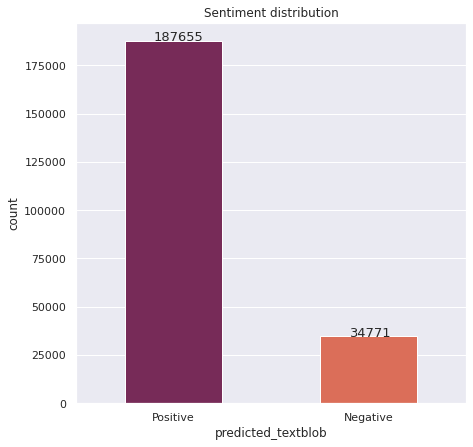

In [135]:
sns.set(rc={'figure.figsize':(7,7)})
labels = ['Positive', 'Negative']

ax = sns.countplot(x="predicted_textblob", data=new2, palette="rocket")
for i in ax.patches:
  ax.text(x=i.get_x()+0.3,y=i.get_height(), s=str(i.get_height()),fontsize=13)
  i.set_width(0.5)
  i.set_x(i.get_x()+0.15)

ax.set_title('Sentiment distribution')

ax.set_xticklabels(labels)